# Week 8<br>Analyzing and Visualizing Large Datasets

- Oct 25, 2023
- Section 401

## This week's agenda: working with big data

**By example:**
- Open Street Map data
- Census data
- NYC taxi cab trips

In [1]:
# Initial imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd

In [2]:
# Ignore numpy warnings
np.seterr("ignore");

Use *intake* to load the dataset instructions for this week

In [3]:
import intake

In [4]:
datasets = intake.open_catalog("./datasets.yml")

Import datashader and related modules:

In [5]:
# Datashader imports
import datashader as ds
import datashader.transfer_functions as tf

In [6]:
# Color-related imports
from datashader.colors import Greys9, viridis, inferno
from colorcet import fire

## Load the Census data to a dask array

In [7]:
# Load the data
# REMEMBER: this will take some time to download the first time
census_ddf = datasets.census.to_dask()

Corrupted thrift data at  2 :  13 11
Corrupted thrift data at  13 :  47 11
Corrupted thrift data at  23 :  66 10
Corrupted thrift data at  28 :  90 15
Corrupted thrift data at  33 :  106 15
Corrupted thrift data at  45 :  -125 0
Corrupted thrift data at  46 :  -118 11
Corrupted thrift data at  47 :  -118 15
Corrupted thrift data at  58 :  -85 15
Corrupted thrift data at  59 :  -81 0
Corrupted thrift data at  62 :  -74 13
Corrupted thrift data at  63 :  -70 15
Corrupted thrift data at  64 :  -69 10
Corrupted thrift data at  95 :  0 10
Corrupted thrift data at  103 :  32 14
Corrupted thrift data at  203 :  16 15
Corrupted thrift data at  213 :  34 11
Corrupted thrift data at  226 :  52 11
Corrupted thrift data at  249526746 :  24 14
Corrupted thrift data at  249526749 :  35 10
Corrupted thrift data at  249526750 :  49 13
Corrupted thrift data at  249526757 :  80 14
Corrupted thrift data at  249526759 :  94 10
Corrupted thrift data at  249756615 :  107 14
Corrupted thrift data at  2497566

TypeError: An error occurred while calling the read_parquet method registered to the pandas backend.
Original Message: 'NoneType' object is not iterable

In [ ]:
census_ddf

In [ ]:
census_ddf.head()

Setup canvas parameters for USA image:

In [ ]:
from datashader.utils import lnglat_to_meters

In [ ]:
# Sensible lat/lng coordinates for U.S. cities
# NOTE: these are in lat/lng so EPSG=4326
USA = [(-124.72,  -66.95), (23.55, 50.06)]

# Get USA xlim and ylim in meters (EPSG=3857)
USA_xlim_meters, USA_ylim_meters = [list(r) for r in lnglat_to_meters(USA[0], USA[1])]

In [ ]:
# Define some a default plot width & height
plot_width  = 900
plot_height = int(plot_width*7.0/12)

Use a custom color scheme to map racial demographics:

In [ ]:
color_key = {"w": "aqua", "b": "lime", "a": "red", "h": "fuchsia", "o": "yellow"}

## Can we learn more than just population density and race?

We can use *xarray* to slice the array of aggregated pixel values to examine specific aspects of the data.

### Question #1: Where do African Americans live?

Use the `sel()` function of the *xarray* array

In [ ]:
# Step 1: Setup canvas
cvs = ds.Canvas(plot_width=plot_width, plot_height=plot_height)

# Step 2: Aggregate and count race category
aggc = cvs.points(census_ddf, "easting", "northing", agg=ds.count_cat("race"))

# NEW: Select only African Americans (where "race" column is equal to "b")
agg_b = aggc.sel(race="b")

# Step 3: Shade and set background
img = tf.shade(agg_b, cmap=fire, how="eq_hist")
img = tf.set_background(img, "black")

img

### Question #2: How to identify diverse areas?

**Goal:** Select pixels where each race has a non-zero count.

In [ ]:
(aggc.sel(race=['w', 'b', 'a', 'h']) > 0).all(dim='race')

In [ ]:
# Do a "logical and" operation across the "race" dimension
# Pixels will be "True" if the pixel has a positive count for each race
diverse_selection = (aggc.sel(race=['w', 'b', 'a', 'h']) > 0).all(dim='race')

diverse_selection

In [ ]:
# Select the pixel values where our diverse selection criteria is True
agg2 = aggc.where(diverse_selection).fillna(0)

# and shade using our color key
img = tf.shade(agg2, color_key=color_key)
img = tf.set_background(img,"black")

img 

### Question #3: Where is African American population greater than the White population?


In [ ]:
# Select where the "b" race dimension is greater than the "w" race dimension
selection = aggc.sel(race='b') > aggc.sel(race='w') 

selection

In [ ]:
# Select based on the selection criteria
agg3 = aggc.where(selection).fillna(0)

img = tf.shade(agg3, color_key=color_key)
img = tf.set_background(img, "black")

img

## Now let's make it interactive!


**Let's use hvplot**

In [14]:
# Initialize hvplot and dask
import hvplot.pandas
import hvplot.dask # NEW: dask works with hvplot too!

import holoviews as hv
import geoviews as gv

::: {.callout-note}
## Side note: persisting dask arrays in memory

To speed up interactive calculations, you can "persist" a dask array in memory (load the data fully into memory). You should have at least 16 GB of memory to avoid memory errors, though!

If not persisted, the data will be loaded on demand to avoid memory issues, which will slow the interactive nature of the plots down slightly.

:::

In [ ]:
# UNCOMMENT THIS LINE IF YOU HAVE AT LEAST 16 GB OF MEMORY
census_ddf = census_ddf.persist()

In [ ]:
census_ddf

In [ ]:
# Plot the points
points = census_ddf.hvplot.points(
    x="easting",
    y="northing",
    datashade=True, # NEW: tell hvplot to use datashader!
    aggregator=ds.count(),
    cmap=fire,
    geo=True,
    crs=3857, # Input data is in 3857, so we need to tell hvplot
    frame_width=plot_width,
    frame_height=plot_height,
    xlim=USA_xlim_meters, # NEW: Specify the xbounds in meters (EPSG=3857)
    ylim=USA_ylim_meters, # NEW: Specify the ybounds in meters (EPSG=3857)
)

# Put a tile source behind it
bg = gv.tile_sources.CartoDark

bg * points

**Note:** interactive features (panning, zooming, etc) can be *slow*, but the map will eventually re-load!

### We can visualize color-coded race interactively as well

Similar syntax to previous examples...

In [ ]:
# Points with categorical colormap
race_map = census_ddf.hvplot.points(
    x="easting",
    y="northing",
    datashade=True,
    c="race",  # NEW: color pixels by "race" column
    aggregator=ds.count_cat("race"),  # NEW: specify the aggregator
    cmap=color_key,  # NEW: use our custom color map dictionary
    crs=3857,
    geo=True,
    frame_width=plot_width,
    frame_height=plot_height,
    xlim=USA_xlim_meters,
    ylim=USA_ylim_meters,
)

bg = gv.tile_sources.CartoDark

bg * race_map

## Use case: exploring gerrymandering

We can easily overlay Congressional districts on our map...

In [ ]:
# Load congressional districts and convert to EPSG=3857
districts = gpd.read_file('./data/cb_2015_us_cd114_5m').to_crs(epsg=3857)

In [ ]:
# Plot the district map
districts_map = districts.hvplot.polygons(
    geo=True,
    crs=3857,
    line_color="white",
    fill_alpha=0,
    frame_width=plot_width,
    frame_height=plot_height,
    xlim=USA_xlim_meters,
    ylim=USA_ylim_meters
    
)

bg * districts_map

In [32]:
# Combine the background, race map, and districts into a single map
img = bg * race_map * districts_map

img

:DynamicMap   []
   :Overlay
      .WMTS.I     :WMTS   [Longitude,Latitude]
      .RGB.I      :RGB   [easting,northing]   (R,G,B,A)
      .Polygons.I :Polygons   [Longitude,Latitude]

## Example 3: NYC taxi data

12 million taxi trips from 2015...

In [8]:
# Load from our intake catalog
# Remember: this will take some time to download the first time!
taxi_ddf = datasets.nyc_taxi_wide.to_dask()

In [9]:
taxi_ddf

Dask DataFrame Structure:
              tpep_pickup_datetime tpep_dropoff_datetime passenger_count trip_distance pickup_x pickup_y dropoff_x dropoff_y fare_amount tip_amount dropoff_hour pickup_hour
npartitions=1                                                                                                                                                               
                    datetime64[ns]        datetime64[ns]           uint8       float32  float32  float32   float32   float32     float32    float32        uint8       uint8
                               ...                   ...             ...           ...      ...      ...       ...       ...         ...        ...          ...         ...
Dask Name: read-parquet, 1 graph layer

In [10]:
print(f"{len(taxi_ddf)} Rows")
print(f"Columns: {list(taxi_ddf.columns)}")

11842094 Rows
Columns: ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'pickup_x', 'pickup_y', 'dropoff_x', 'dropoff_y', 'fare_amount', 'tip_amount', 'dropoff_hour', 'pickup_hour']


In [11]:
taxi_ddf.head()

tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  trip_distance  \
0  2015-01-15 19:05:39   2015-01-15 19:23:42                1           1.59   
1  2015-01-10 20:33:38   2015-01-10 20:53:28                1           3.30   
2  2015-01-10 20:33:38   2015-01-10 20:43:41                1           1.80   
3  2015-01-10 20:33:39   2015-01-10 20:35:31                1           0.50   
4  2015-01-10 20:33:39   2015-01-10 20:52:58                1           3.00   

    pickup_x   pickup_y  dropoff_x  dropoff_y  fare_amount  tip_amount  \
0 -8236963.0  4975552.5 -8234835.5  4975627.0         12.0        3.25   
1 -8237826.0  4971752.5 -8237020.5  4976875.0         14.5        2.00   
2 -8233561.5  4983296.5 -8232279.0  4986477.0          9.5        0.00   
3 -8238654.0  4970221.0 -8238124.0  4971127.0          3.5        0.00   
4 -8234433.5  4977363.0 -8238107.5  4974457.0         15.0        0.00   

   dropoff_hour  pickup_hour  
0            19           19  
1            20           20  
2            20           20  
3            20           20  
4            20           20

In [12]:
# Trim to the columns
taxi_ddf = taxi_ddf[
    [
        "passenger_count",
        "pickup_x",
        "pickup_y",
        "dropoff_x",
        "dropoff_y",
        "dropoff_hour",
        "pickup_hour",
    ]
]

### Exploring the taxi pick ups...

In [15]:
pickups_map = taxi_ddf.hvplot.points(
    x="pickup_x",
    y="pickup_y",
    cmap=fire,
    datashade=True,
    frame_width=800,
    frame_height=600,
    geo=True, 
    crs=3857
)

gv.tile_sources.CartoDark * pickups_map

:DynamicMap   []
   :Overlay
      .WMTS.I :WMTS   [Longitude,Latitude]
      .RGB.I  :RGB   [pickup_x,pickup_y]   (R,G,B,A)

Group by the hour column to add a slider widget:

In [ ]:
pickups_map = taxi_ddf.hvplot.points(
    x="pickup_x",
    y="pickup_y",
    groupby="pickup_hour",
    cmap=fire,
    datashade=True,
    frame_width=800,
    frame_height=600,
    geo=True, 
    crs=3857
)

gv.tile_sources.CartoDark * pickups_map

### Comparing pickups and dropoffs

- Pixels with more pickups: *shaded red*
- Pixels with more dropoffs: *shaded blue*

In [ ]:
# Bounds in meters for NYC (EPSG=3857)
NYC = [(-8242000,-8210000), (4965000,4990000)]

# Set a plot width and height
plot_width  = int(750)
plot_height = int(plot_width//1.2)

In [ ]:
def create_merged_taxi_image(
    x_range, y_range, w=plot_width, h=plot_height, how="eq_hist"
):
    """
    Create a merged taxi image, showing areas with: 
    
    - More pickups than dropoffs in red
    - More dropoffs than pickups in blue
    """
    # Step 1: Create the canvas
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)

    # Step 2: Aggregate the pick ups
    picks = cvs.points(taxi_ddf, "pickup_x", "pickup_y", ds.count("passenger_count"))

    # Step 2: Aggregate the drop offs
    drops = cvs.points(taxi_ddf, "dropoff_x", "dropoff_y", ds.count("passenger_count"))

    # Rename to same names
    drops = drops.rename({"dropoff_x": "x", "dropoff_y": "y"})
    picks = picks.rename({"pickup_x": "x", "pickup_y": "y"})

    # Step 3: Shade
    # NEW: shade pixels there are more drop offs than pick ups
    # These are colored blue
    more_drops = tf.shade(
        drops.where(drops > picks), cmap=["darkblue", "cornflowerblue"], how=how
    )

    # Step 3: Shade
    # NEW: shade pixels where there are more pick ups than drop offs
    # These are colored red
    more_picks = tf.shade(
        picks.where(picks > drops), cmap=["darkred", "orangered"], how=how
    )

    # Step 4: Combine
    # NEW: add the images together!
    img = tf.stack(more_picks, more_drops)

    return tf.set_background(img, "black")

In [ ]:
create_merged_taxi_image(NYC[0], NYC[1])

**Takeaway:** pickups occur more often on major roads, and dropoffs on smaller roads

## Let's generate a time-lapse GIF of drop-offs over time

Powerful tool for visualizing trends over time

### Define some functions...

**Important:** We can convert our datashaded images to the format of the Python Imaging Library (PIL) to visualize 

In [45]:
def create_taxi_image(df, x_range, y_range, w=plot_width, h=plot_height, cmap=fire):
    """Create an image of taxi dropoffs, returning a Python Imaging Library (PIL) image."""
    
    # Step 1: Create the canvas
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    
    # Step 2: Aggregate the dropoff positions, coutning number of passengers
    agg = cvs.points(df, 'dropoff_x', 'dropoff_y',  ds.count('passenger_count'))
    
    # Step 3: Shade
    img = tf.shade(agg, cmap=cmap, how='eq_hist')
    
    # Set the background
    img = tf.set_background(img, "black")
    
    # NEW: return an PIL image
    return img.to_pil()

In [46]:
def convert_to_12hour(hr24):
    """Convert from 24 hr to 12 hr."""
    from datetime import datetime
    d = datetime.strptime(str(hr24), "%H")
    return d.strftime("%I %p")

In [50]:
def plot_dropoffs_by_hour(fig, data_all_hours, hour, x_range, y_range):
    """Plot the dropoffs for particular hour."""
    
    # Trim to the specific hour
    df_this_hour = data_all_hours.loc[data_all_hours["dropoff_hour"] == hour]

    # Create the datashaded image for this hour
    img = create_taxi_image(df_this_hour, x_range, y_range)

    # Plot the image on a matplotlib axes
    # Use imshow()
    plt.clf()
    ax = fig.gca()
    ax.imshow(img, extent=[x_range[0], x_range[1], y_range[0], y_range[1]])
    
    # Format the axis and figure
    ax.set_aspect("equal")
    ax.set_axis_off()
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)

    # Optional: Add a text label for the hour
    ax.text(
        0.05,
        0.9,
        convert_to_12hour(hour),
        color="white",
        fontsize=40,
        ha="left",
        transform=ax.transAxes,
    )

    # Draw the figure and return the image
    # This converts our matplotlib Figure into a format readable by imageio
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype="uint8")
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return image

### Strategy:

1. Create a datashaded image for each hour of taxi dropoffs, return as a PIL image object
1. Use matplotlib's `imshow()` to plot each datashaded image to a matplotlib Figure
1. Return each matplotlib Figure in a format readable by the `imageio` library 
1. Combine all of our images for each hours into a GIF using the `imageio` library

In [51]:
import imageio

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


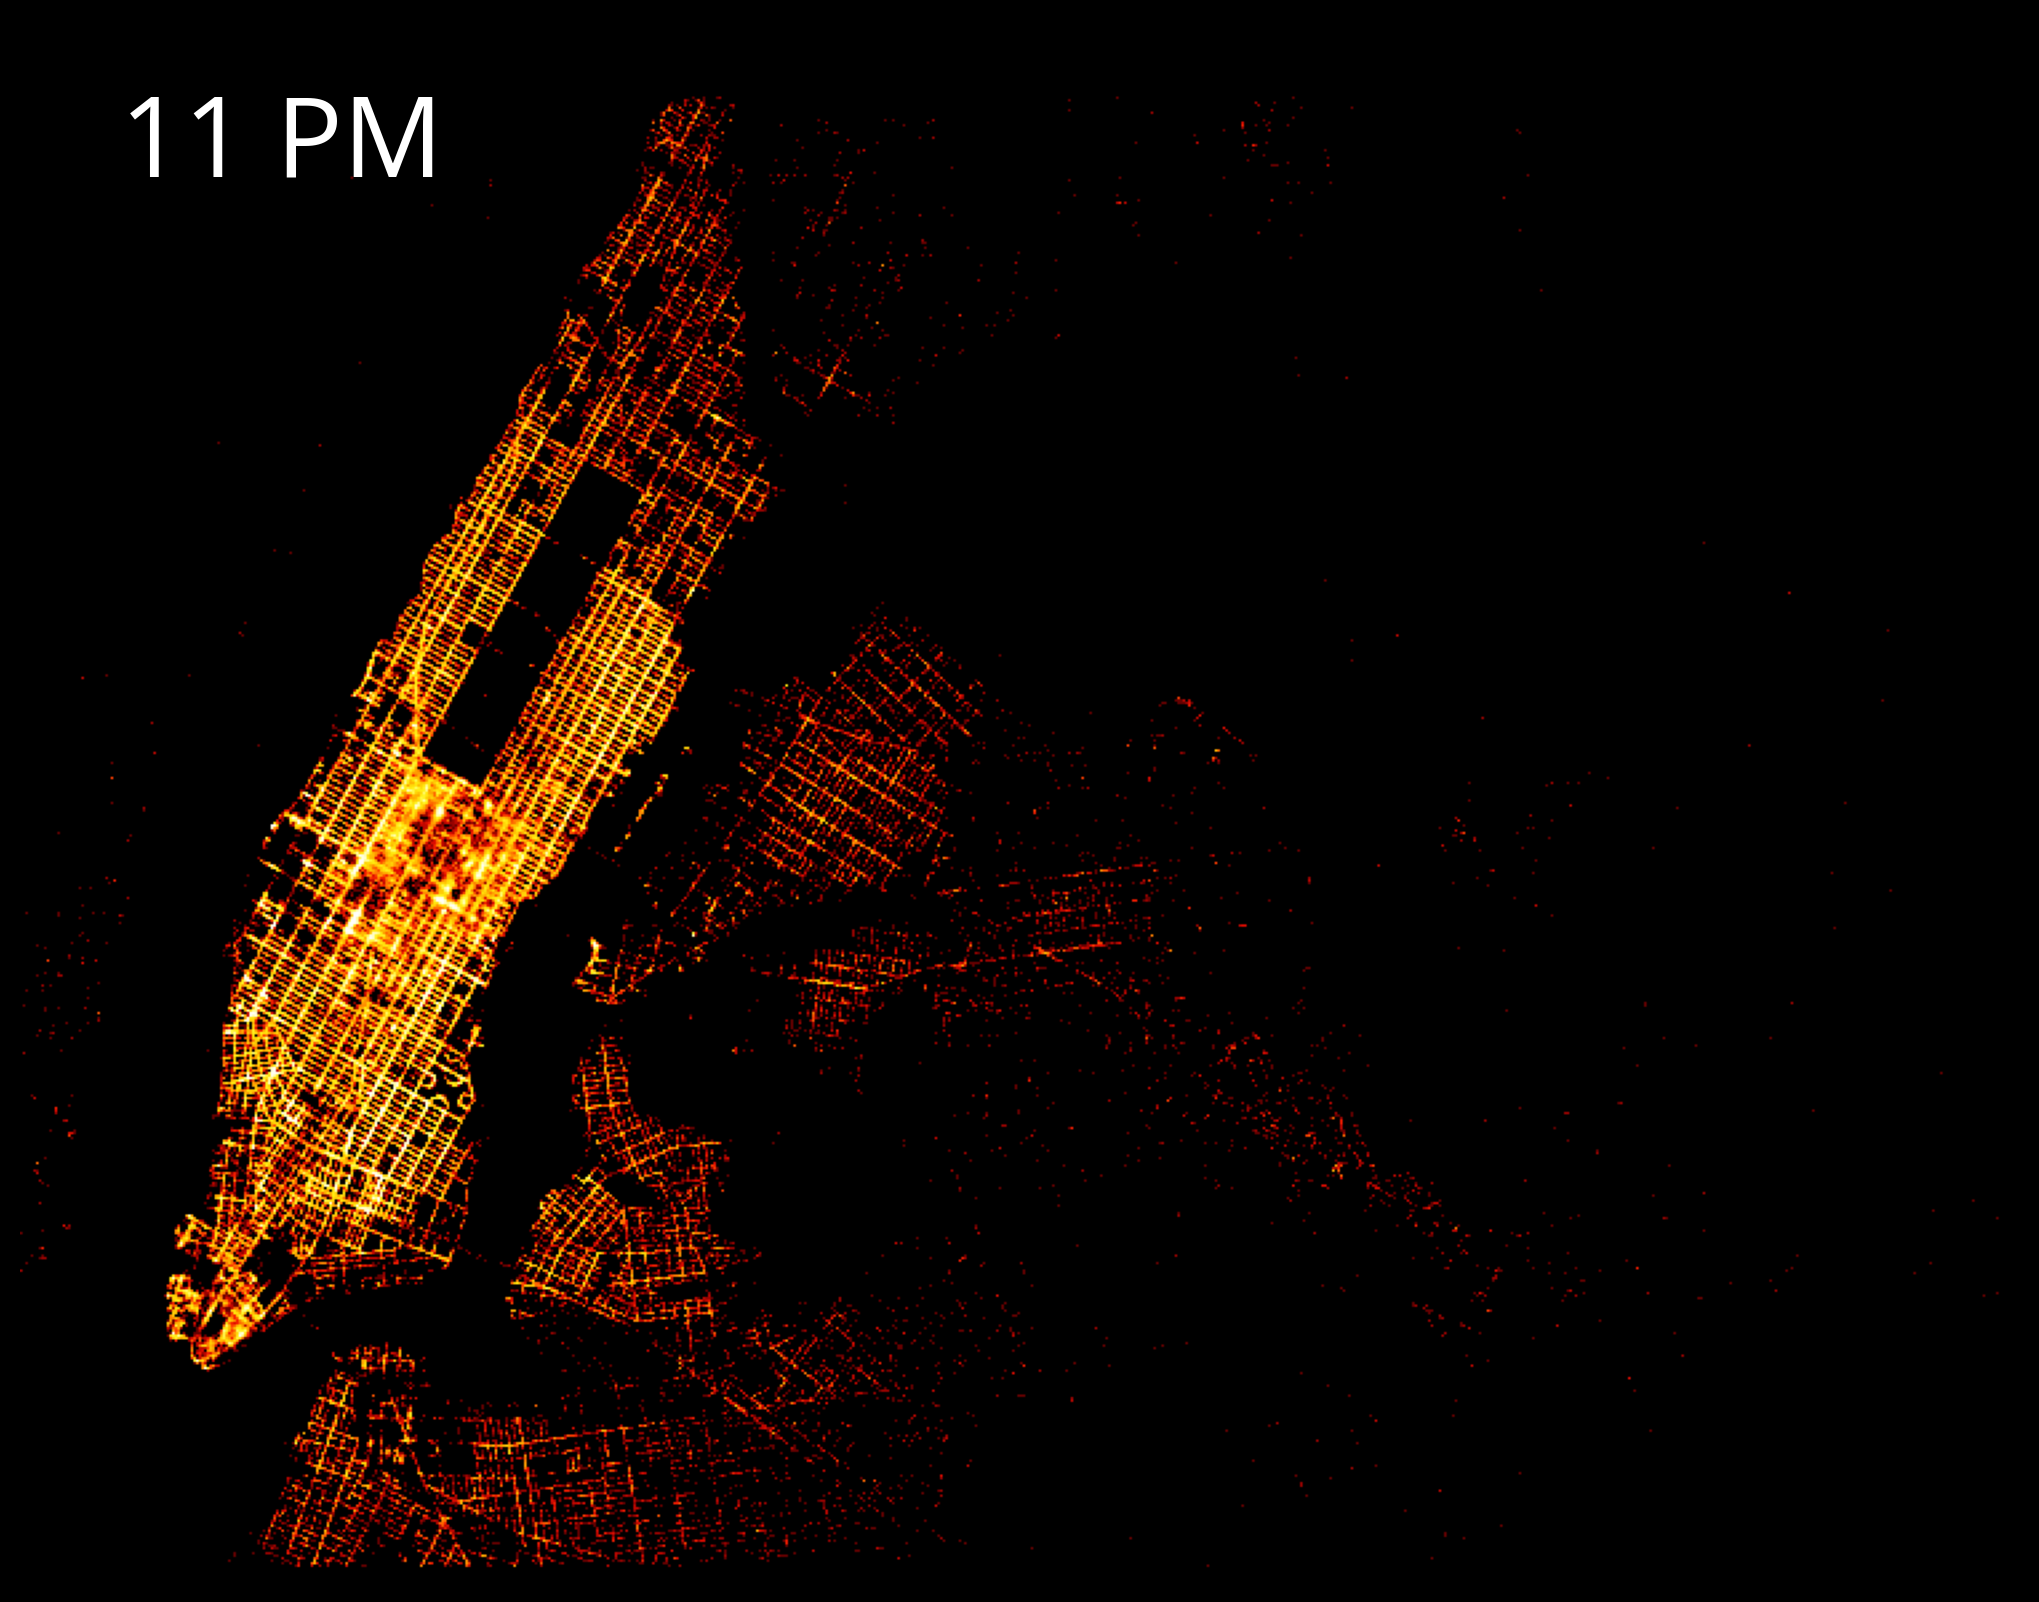

In [75]:
# Create a figure
fig, ax = plt.subplots(figsize=(10, 10), facecolor="black")

# Create an image for each hour
imgs = []
for hour in range(24):

    # Plot the datashaded image for this specific hour
    print(hour)
    img = plot_dropoffs_by_hour(fig, taxi_ddf, hour, x_range=NYC[0], y_range=NYC[1])
    imgs.append(img)


# Combing the images for each hour into a single GIF
imageio.mimsave("dropoffs.gif", imgs, duration=1000);

## Interesting aside: Beyond hvplot

**Analyzing hourly and weekly trends for taxis using holoviews**

- We'll load taxi data from 2016 that includes the number of pickups per hour.
- Visualize weekly and hourly trends using a *radial heatmap*

In [ ]:
df = pd.read_csv('./data/nyc_taxi_2016_by_hour.csv.gz', parse_dates=['Pickup_date'])

In [ ]:
df.head()

### Add date-related columns with `strftime`

We can use the `strftime()` function of a datetime Series to extract specific aspects of a date object. In this case, we are interested in:

- Day of Week (Monday, Tuesday, etc) and hour of day
- Week of Year

To find the specific string notation for these, use: http://strftime.org

In [ ]:
# create relevant time columns
df["Day & Hour"] = df["Pickup_date"].dt.strftime("%A %H:00")
df["Week of Year"] = df["Pickup_date"].dt.strftime("Week %W")
df["Date"] = df["Pickup_date"].dt.strftime("%Y-%m-%d")

In [ ]:
df.head()

### Let's plot a radial heatmap

The binning dimensions of the heat map will be:

- Day of Week and Hour of Day
- Week of Year

A radial heatmap can be read similar to tree rings:

- The center of the heatmap will represent the first week of the year, while the outer edge is the last week of the year
- Rotating clockwise along a specific ring tells you the day/hour.

In [ ]:
# Create a Holoviews HeatMap option
cols = ["Day & Hour", "Week of Year", "Pickup_Count", "Date"]
heatmap = hv.HeatMap(
    df[cols], kdims=["Day & Hour", "Week of Year"], vdims=["Pickup_Count", "Date"]
)

In [ ]:
heatmap.opts(
    radial=True,
    height=600,
    width=600,
    yticks=None,
    xmarks=7,
    ymarks=3,
    start_angle=np.pi * 19 / 14,
    xticks=(
        "Friday",
        "Saturday",
        "Sunday",
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
    ),
    tools=["hover"],
    cmap="fire"
)

### Trends

- Taxi pickup counts are high between 7-9am and 5-10pm during weekdays which business hours as expected. In contrast, during weekends, there is not much going on until 11am.
- Friday and Saterday nights clearly stand out with the highest pickup densities as expected.
- Public holidays can be easily identified. For example, taxi pickup counts are comparetively low around Christmas and Thanksgiving.
- Weather phenomena also influence taxi service. There is a very dark stripe at the beginning of the year starting at Saturday 23rd and lasting until Sunday 24th. Interestingly, there was one of the biggest blizzards in the history of NYC.

### Useful reference: the Holoviews example gallery

This radial heatmap example, and many more examples beyond hvplot available:

[https://holoviews.org/gallery/index.html](https://holoviews.org/gallery/index.html)

## Exercise: Datashading Philly parking violations data

#### Download the data

- A (large) CSV of parking violation data is available for download at: [https://musa550.s3.amazonaws.com/parking_violations.csv](https://musa550.s3.amazonaws.com/parking_violations.csv)
- Navigate to your browser, plug in the above URL, and download the data
- The data is from Open Data Philly: [https://www.opendataphilly.org/dataset/parking-violations](https://www.opendataphilly.org/dataset/parking-violations)
- Input data is in EPSG=4326
- **Remember**: You will need to convert latitude/longitude to Web Mercator (epsg=3857) to work with datashader.

### Step 1: Use `dask` to load the data

- The `dask.dataframe` module includes a [`read_csv()`](https://docs.dask.org/en/latest/dataframe-api.html#dask.dataframe.read_csv) function just like pandas 
- You'll want to specify the `assume_missing=True` keyword for that function: that will let dask know that some columns are allowed to have missing values

In [53]:
import dask.dataframe as dd

In [54]:
# I downloaded the data and moved it to the "data/" folder of my week-8 repository locally
df = dd.read_csv("data/parking_violations.csv", assume_missing=True)

In [55]:
df

Dask DataFrame Structure:
                   lon      lat
npartitions=4                  
               float64  float64
                   ...      ...
                   ...      ...
                   ...      ...
                   ...      ...
Dask Name: read-csv, 1 graph layer

In [56]:
len(df)

9412858

In [57]:
df.head()

lon        lat
0 -75.158937  39.956252
1 -75.154730  39.955233
2 -75.172386  40.034175
3        NaN        NaN
4 -75.157291  39.952661

### Step 2: Remove any rows with missing geometries

Remove rows that have NaN for either the `lat` or `lon` columns (*hint*: use the dropna() function!)

### Step 3: Convert lat/lng to Web Mercator coordinates (x, y)

Add two new columns, `x` and `y`, that represent the coordinates in the EPSG=3857 CRS.

**Hint:** Use datashader's `lnglat_to_meters()` function.

In [61]:
from datashader.utils import lnglat_to_meters

### Step 4: Get the x/y range for Philadelphia for our canvas

- Convert the lat/lng bounding box into Web Mercator EPSG=3857 
- Use the `lnglat_to_meters()` function to do the conversion
- You should have two variables `x_range` and `y_range` that give you the corresponding `x` and `y` bounds 

In [66]:
# Use lat/lng bounds for Philly
# This will exclude any points that fall outside this region
PhillyBounds = [( -75.28,  -74.96), (39.86, 40.14)]

### Step 5: Datashade the dataset
 
Create a matplotlib figure with the datashaded image of the parking violation dataset.

### Step 6: Make an interactive map

Use hvplot to make an interactive version of your datashaded image.

## That's it!

- Next week: dashboards and presenting your results on the web!
- See you on Monday!